In [1]:
from skimage import io, morphology, color, util, filters, draw
from scipy import stats
import numpy as np
from PIL import Image
import pandas as pd
import sknw

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="Set2", context="talk")
from IPython.display import display
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

data = "data/"
overview_file = "image_overview.csv"

In [12]:
def calculate_radius(p1, p2, p3):
    # from https://stackoverflow.com/questions/28910718/give-3-points-and-a-plot-circle/50974391#50974391
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return None

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return radius

def calculate_curvatures(points, dist=10):
    
    curvatures_all = list()
    
    for i in range(len(ps)):

        cur_curvatures = list()
        cur_line = ps[i]

        for i in range(dist, len(cur_line[:,0])-dist):

            xm1, x, xp1 = cur_line[i-dist,0], cur_line[i,0], cur_line[i+dist,0]
            ym1, y, yp1 = cur_line[i-dist,1], cur_line[i,1], cur_line[i+dist,1]

            r = calculate_radius((xm1, ym1), (x,y), (xp1, yp1))
            if r is not None:
                cur_curvatures.append(1/r)
                
        curvatures_all.extend(cur_curvatures)
    
    if len(curvatures_all) != 0:
        return curvatures_all
    else:
        return None
    
def calculate_angles(graph, n_points = 10, n_min = 10):

    nodes = graph.nodes()
    angles = list()

    for i in nodes:

        if len(graph.edges(i)) != 3:
            continue

        neighbors_idx = [j for j in graph.neighbors(i)]
        neighbors_pts = np.array([graph[i][j]['pts'] for j in neighbors_idx])
        neighbors_len = [len(j) for j in neighbors_pts]

        if sum(np.array(neighbors_len) > n_min) != 3:
            continue

        c = graph.nodes(data=True)[i]["o"]

        # find closest n points
        p = [0, 0, 0]
        for i in range(3):
            p[i] = neighbors_pts[i][np.argsort(np.sum((neighbors_pts[i] - c)**2, axis=1))[:n_points],:]

        # linear regression through all sets
        sets = [[0,1], [1,2], [0,2]]
        r_vals = list()
        for i in range(3):
            a, b = sets[i][0], sets[i][1]
            temp_data = np.concatenate((p[a], p[b]), axis=0)

            _, _, r_value, _, _ = stats.linregress(temp_data)
            r_squared = r_value**2

            r_vals.append(r_squared)

        best_idx = sets[np.argmax(r_vals)]
        last_idx = list(set([0,1,2]).difference(set(best_idx)))[0]

        # create two lines, one through two best sets and one through last set. 
        temp_data = np.concatenate((p[best_idx[0]], p[best_idx[1]]), axis=0)
        slope1, _, _, _, _ = stats.linregress(temp_data)
        slope2, _, _, _, _ = stats.linregress(p[last_idx][:,0], p[last_idx][:,1])
        
        if np.isnan(slope1): slope1=1000
        if np.isnan(slope2): slope2=1000

        alpha, beta = np.arctan(slope1)*180/3.14, np.arctan(slope2)*180/3.14
        angle = alpha - beta
        #angle = (m1 - m2)*180/3.14
        if angle < 0:
            angle = -angle
        #if angle > 90:
        #    angle = 180 - angle
        if np.isnan(angle):
            angle = 90

        angles.append(angle)
        
    return angles

def space_filling(img):
    
    convex_hull = morphology.convex_hull_image(img)
    
    return np.sum(img)/np.sum(convex_hull)

In [13]:
img_overview = pd.read_csv(data+overview_file)
img_overview.head(10)

,img_index,input_img_fname,target_img_fname,binary_threshold,segmentation_fname,gene
0,0,0_brightfield.jpg,0_fluorescence.jpg,15,0_target.png,wt
1,1,1_brightfield.jpg,1_fluorescence.jpg,25,1_target.png,wt
2,2,2_brightfield.jpg,2_fluorescence.jpg,15,2_target.png,wt
3,3,3_brightfield.jpg,3_fluorescence.jpg,25,3_target.png,wt
4,4,4_brightfield.jpg,4_fluorescence.jpg,15,4_target.png,wt
5,5,5_brightfield.jpg,5_fluorescence.jpg,25,5_target.png,wt
6,6,6_brightfield.jpg,6_fluorescence.jpg,15,6_target.png,wt
7,9,9_brightfield_chsC.jpg,9_fluorescence_chsC.jpg,20,9_target.png,chsc
8,10,10a_brightfield_chsC.png,10a_fluorescence_chsC.png,25,10a_target.jpg,chsc
9,11,10b_brightfield_chsC.png,10b_fluorescence_chsC.png,25,10b_target.jpg,chsc


In [46]:
branching_freqs = list()
curvatures_all = list()
angles_all = list()
internodal_all = list()
space_filling_all = list()

pixels_per_hyphal_element = 50

n_hours = 24

for idx in range(len(img_overview)):

    fl_fname = img_overview.at[idx, "target_img_fname"]
    fl_img  = io.imread(data + fl_fname)
    fl_img = fl_img[:,:,2]
    fl_img = util.img_as_ubyte(fl_img)
    
    
    threshold = img_overview.at[idx, "binary_threshold"]

    bin_img = fl_img.copy()
    bin_img[bin_img >= threshold] = 255
    bin_img[bin_img < threshold] = 0

    bin_img = bin_img.astype(np.bool)

    bin_img = morphology.remove_small_objects(bin_img, min_size=10000, connectivity=2)

    bin_img = filters.median(bin_img, selem=morphology.square(5))

    ske_img = morphology.skeletonize(bin_img)
    ske_img = morphology.remove_small_objects(ske_img, min_size=1000, connectivity=2)
    
    # build graph from skeleton
    graph = sknw.build_sknw(ske_img)

    # draw node by o
    nodes = graph.nodes()
    bs = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))>=3])
    ts = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))<=2])
    
    ps = list()
    internodal_lengths = list()

    for (s,e) in graph.edges():
        ps.append(graph[s][e]['pts'].astype(np.int32))
        
        if len([j for j in graph.neighbors(s)]) == 3 and len([j for j in graph.neighbors(e)]) == 3:
            internodal_lengths.append(len(graph[s][e]['pts'].astype(np.int32)))
        
    internodal_all.append(internodal_lengths)
    branch_occurence = (len(bs))/graph.size(weight="weight")    
    branching_freqs.append(branch_occurence*pixels_per_hyphal_element/24)    
    
    curvatures = calculate_curvatures(ps)
    curvatures_all.append(curvatures)
        
    angles = calculate_angles(graph)
    angles_all.append(angles)
    
    space_filling_all.append(space_filling(ske_img))
 

# Statistics per image/strain

In [48]:
strain_stats = img_overview.loc[:, ["gene"]].copy()

strain_stats["branching_frequency"] = branching_freqs
strain_stats["space_fillingness"] = space_filling_all
strain_stats["curvature"] = curvatures_all
strain_stats["angle"] = angles_all
strain_stats["internodal_length"] = internodal_all
strain_stats.head(10)

,gene,branching_frequency,space_fillingness,curvature,angle,internodal_length
0,wt,0.015759,0.006635,"[0.0075730958986211525, 0.0075730958986211525,...","[51.70344288049212, 90.74721690685989, 96.7611...","[279, 334, 46, 68, 65, 365, 82, 42, 85, 4, 91,..."
1,wt,0.013036,0.007742,"[0.031228050490911898, 0.02483455621622304, 0....","[87.48090302233821, 88.70861128352912, 58.8440...","[420, 54, 6, 70, 39, 55, 232, 29, 226, 81, 153..."
2,wt,0.014245,0.005726,"[0.017440987965908723, 0.008393915280506137, 0...","[102.90021534501929, 102.38589338418811, 98.04...","[30, 3, 20, 11, 43, 190, 317, 10, 3, 11, 3, 3,..."
3,wt,0.018739,0.012152,"[0.017440987965908726, 0.03409816821835206, 0....","[85.06121041853595, 99.9565419066177, 73.77898...","[259, 195, 28, 197, 359, 426, 387, 232, 12, 28..."
4,wt,0.021226,0.013627,"[0.033648295041581386, 0.02246963455025197, 0....","[95.24475718411489, 80.03441271512409, 84.0150...","[141, 112, 139, 18, 66, 65, 53, 33, 23, 118, 3..."
5,wt,0.018071,0.011933,"[0.00839391528050614, 0.00839391528050614, 0.0...","[81.13252807025474, 63.79511871324702, 51.1796...","[26, 13, 42, 233, 175, 185, 55, 99, 352, 144, ..."
6,wt,0.019359,0.010139,"[0.017246506858208475, 0.004016339575624078, 0...","[85.62038501913656, 79.90739973177233, 87.1023...","[274, 243, 125, 178, 84, 16, 35, 47, 75, 40, 7..."
7,chsc,0.024396,0.016236,"[0.03641785203646149, 0.03641785203646149, 0.0...","[68.46937680683112, 94.37708167609264, 40.6307...","[77, 125, 157, 156, 32, 117, 99, 63, 18, 64, 1..."
8,chsc,0.028973,0.021730,"[0.026888532719620644, 0.01869129492474109, 0....","[88.82162217165173, 77.09184130445527, 84.5908...","[37, 35, 78, 45, 14, 39, 24, 18, 23, 31, 37, 2..."
9,chsc,0.022213,0.013664,"[0.014242182297397127, 0.014242182297397127, 0...","[86.63622539985259, 39.48559625264757, 65.6219...","[36, 8, 68, 43, 62, 44, 19, 43, 43, 77, 52, 9,..."


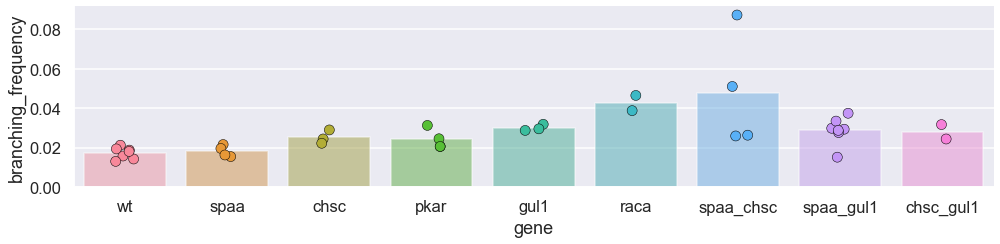

In [62]:
gene_order = ["wt", "spaa", "chsc", "pkar", "gul1", "raca", "spaa_chsc", "spaa_gul1", "chsc_gul1"]

sns.catplot(data=strain_stats, x="gene", y="branching_frequency", 
            alpha=0.5, ci=False, aspect=4, kind="bar", legend_out=True, height=3.5,
            order = gene_order)
ax = sns.stripplot(data=strain_stats, x="gene", hue="gene", 
                   y="branching_frequency", edgecolor="k", linewidth=0.5, size=10,
                   order = gene_order, hue_order = gene_order)

ax.legend_.remove()

plt.tight_layout()

plt.savefig("branching.jpg")

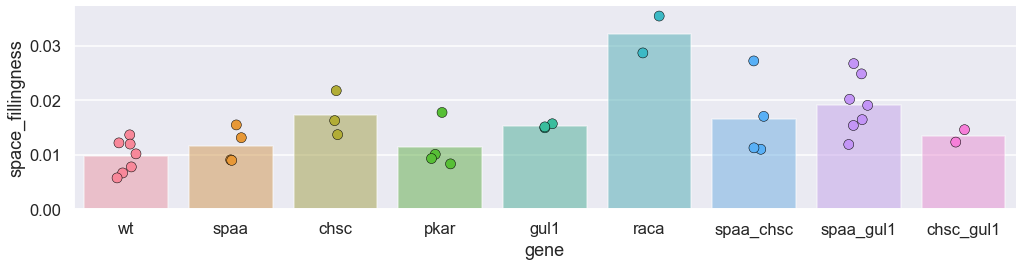

In [50]:
sns.catplot(data=strain_stats, x="gene", y="space_fillingness", 
            alpha=0.5, ci=False, aspect=4, kind="bar", legend_out=True, height=3.5,
            order = gene_order)
ax = sns.stripplot(data=strain_stats, x="gene", hue="gene", 
                   y="space_fillingness", edgecolor="k", linewidth=0.5, size=10,
                   order = gene_order, hue_order = gene_order)

ax.legend_.remove()

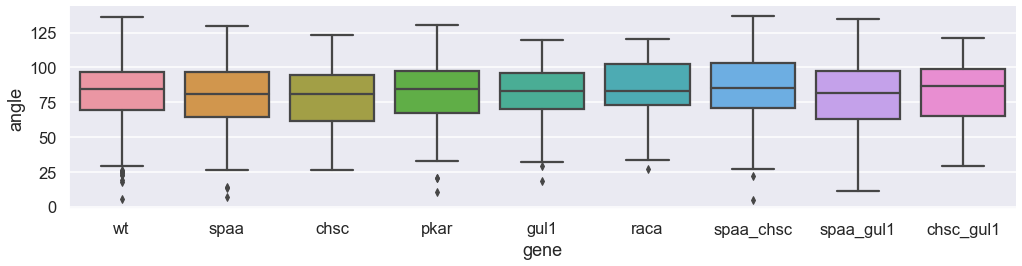

In [51]:
angle_df = strain_stats.loc[:, ["gene", "angle"]].copy()
angle_df = angle_df.explode('angle')

angle_df["angle"] = angle_df["angle"].astype(float)

sns.catplot(data=angle_df, x="gene", y="angle", kind="box", aspect=4, height=3.5, order = gene_order)

#g = sns.FacetGrid(data=angle_df, hue="gene", xlim=(0, 180))
#g.map(sns.boxplot, "angle")

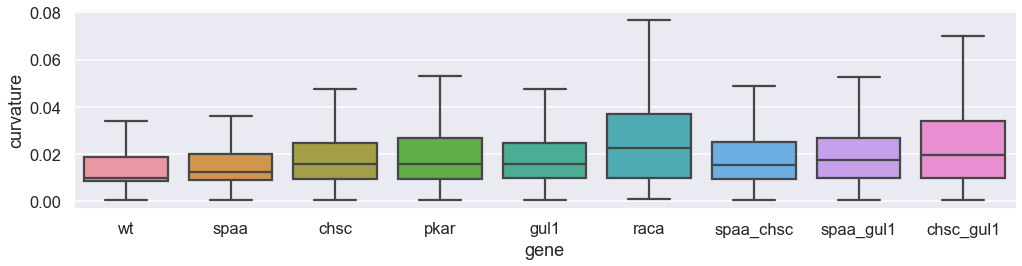

In [52]:
curvature_df = strain_stats.loc[:, ["gene", "curvature"]].copy()
curvature_df = curvature_df.explode('curvature')

curvature_df["curvature"] = curvature_df["curvature"].astype(float)

sns.catplot(data=curvature_df, x="gene", y="curvature", kind="box", showfliers = False, aspect=4, height=3.5,
            order = gene_order)

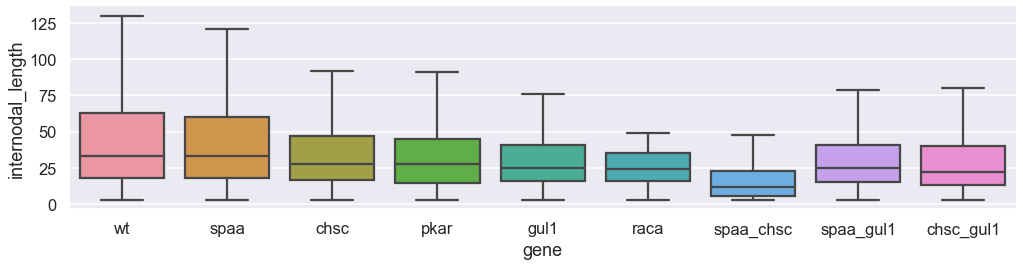

In [54]:
internodal_df = strain_stats.loc[:, ["gene", "internodal_length"]].copy()
internodal_df = internodal_df.explode('internodal_length')

internodal_df["internodal_length"] = internodal_df["internodal_length"].astype(float)

sns.catplot(data=internodal_df, x="gene", y="internodal_length", kind="box", showfliers = False, aspect=4, height=3.5,
            order = gene_order)

In [79]:
strain_stats.loc[:, ["gene", "branching_frequency"]].groupby("gene").agg(['mean', 'std']).reindex(index = gene_order)

branching_frequency          
                         mean       std
gene                                   
wt                   0.017205  0.002948
spaa                 0.018225  0.002855
chsc                 0.025194  0.003450
pkar                 0.024237  0.005033
gul1                 0.030030  0.001610
raca                 0.042606  0.005446
spaa_chsc            0.047613  0.028894
spaa_gul1            0.028798  0.006888
chsc_gul1            0.028034  0.005167

# Create aggregate stats per strain for radar charts

In [202]:
df = strain_stats.loc[:, ["gene", "branching_frequency", "space_fillingness"]] \
     .groupby("gene").mean().reindex(index = gene_order).reset_index()

no_data_append = pd.DataFrame([["apld", np.nan, np.nan]], columns=df.columns)

df = df.append(no_data_append).reset_index(drop=True)
df

,gene,branching_frequency,space_fillingness
0,wt,0.017205,0.009708
1,spaa,0.018225,0.011634
2,chsc,0.025194,0.017210
3,pkar,0.024237,0.011340
4,gul1,0.030030,0.015224
5,raca,0.042606,0.032046
6,spaa_chsc,0.047613,0.016608
7,spaa_gul1,0.028798,0.019193
8,chsc_gul1,0.028034,0.013437
9,apld,NaN,NaN


# Import wetlab results and make aggregate stats for radar charts

In [203]:
wet_df = pd.read_csv(data + "wetlab_numerical_data.csv")
wet_df.head(10)

,sample_index,run,gene,br_1,br_2,bl_1,bl_2,bl_3,bl_4,protein_1,protein_2,lag_1,lag_2,lag_3,lag_4,exp_1,exp_2,exp_3,exp_4
0,1,1,wt,0.4164,0.4233,0.2051,0.2750,0.3471,NaN,2.050491,2.588469,20.504903,21.838555,19.004544,NaN,12.252930,8.835446,9.168859,NaN
1,2,1,spaa,0.1909,0.2019,0.3886,0.3896,0.3185,0.2842,0.841014,1.878118,16.010752,16.928034,20.263608,18.595821,7.254872,7.004704,8.088765,7.921987
2,3,1,chsc,0.2251,0.2156,0.1964,0.2267,0.2462,0.1765,0.436556,0.710286,26.934754,28.602541,25.934082,23.765960,13.675850,7.921987,7.088093,10.507056
3,4,2,wt,0.3665,0.3335,0.2051,0.2750,0.3471,NaN,1.234914,1.748742,20.504903,21.838555,19.004544,NaN,12.252930,8.835446,9.168859,NaN
4,5,2,gul1,0.3140,0.3248,0.3340,0.3144,0.3348,0.2753,4.139693,3.913969,13.759240,18.429042,15.677194,18.595821,9.172826,8.422323,8.589101,9.756552
5,6,2,raca,0.3590,0.3223,0.1587,0.1586,NaN,NaN,3.393856,1.260822,28.173403,28.756876,14.253408,NaN,20.754967,18.837838,43.927170,NaN
6,7,2,chsc_spaa,0.2939,0.2713,0.1540,0.2739,0.3641,NaN,2.559625,1.827087,23.172207,13.669935,12.336283,NaN,20.421550,7.418440,6.168142,NaN
7,8,2,spaa_gul1,0.3179,0.3270,0.3073,0.3376,0.3344,NaN,3.922487,3.645656,13.336522,16.587300,16.253886,NaN,11.836164,9.335566,9.085506,NaN
8,9,2,chsc_gul1,0.4172,0.4154,0.1670,0.1045,0.1430,NaN,2.603683,2.659816,26.589691,10.252451,25.672805,NaN,13.503229,26.923104,20.171490,NaN
9,10,2,pkar,NaN,NaN,0.2061,0.1453,0.2757,NaN,NaN,NaN,20.504903,14.586821,23.172207,NaN,13.419875,22.005262,10.169098,NaN


In [204]:
wet_agg_df = wet_df.loc[:, ["sample_index","run", "gene"]].copy()

wet_agg_df["growth_bioreactor"] = wet_df.loc[:, ["br_1", "br_2"]].mean(axis=1,skipna=True)
wet_agg_df["growth_biolector"] = wet_df.loc[:, ["bl_1", "bl_2", "bl_3", "bl_4"]].mean(axis=1,skipna=True)
wet_agg_df["protein_act"] = wet_df.loc[:, ["protein_1", "protein_2"]].mean(axis=1,skipna=True)
wet_agg_df["lag_duration"] = wet_df.loc[:, ["lag_1", "lag_2", "lag_3", "lag_4"]].mean(axis=1,skipna=True)
wet_agg_df["exp_duration"] = wet_df.loc[:, ["exp_1", "exp_2", "exp_3", "exp_4"]].mean(axis=1,skipna=True)

wet_agg_df

,sample_index,run,gene,growth_bioreactor,growth_biolector,protein_act,lag_duration,exp_duration
0,1,1,wt,0.41985,0.275733,2.319480,20.449334,10.085745
1,2,1,spaa,0.19640,0.345225,1.359566,17.949554,7.567582
2,3,1,chsc,0.22035,0.211450,0.573421,26.309334,9.798246
3,4,2,wt,0.35000,0.275733,1.491828,20.449334,10.085745
4,5,2,gul1,0.31940,0.314625,4.026831,16.615324,8.985200
5,6,2,raca,0.34065,0.158650,2.327339,23.727896,27.839992
6,7,2,chsc_spaa,0.28260,0.264000,2.193356,16.392809,11.336044
7,8,2,spaa_gul1,0.32245,0.326433,3.784072,15.392569,10.085745
8,9,2,chsc_gul1,0.41630,0.138167,2.631749,20.838316,20.199274
9,10,2,pkar,NaN,0.209033,NaN,19.421310,15.198078


In [205]:
run1_genes = list(wet_agg_df.loc[wet_agg_df['run'] == 1, "sample_index"])
run2_genes = list(wet_agg_df.loc[wet_agg_df['run'] == 2, "sample_index"])
num_columns = wet_agg_df.columns[-5:]

# separate datasets
run1_df = wet_agg_df.loc[wet_agg_df["sample_index"].isin(run1_genes)].reset_index(drop=True)
run1_wt = run1_df.loc[run1_df["gene"] == "wt"].reset_index(drop=True)

run2_df = wet_agg_df.loc[wet_agg_df["sample_index"].isin(run2_genes)].reset_index(drop=True)
run2_wt = run2_df.loc[run2_df["gene"] == "wt"].reset_index(drop=True)

# divide by reference
run1_df = run1_df.loc[:, num_columns].div(run1_wt.loc[0, num_columns])
run2_df = run2_df.loc[:, num_columns].div(run2_wt.loc[0, num_columns])

In [206]:
wet_scaled_df = run1_df.append(run2_df).reset_index(drop=True)
wet_scaled_df["gene"] = wet_agg_df["gene"]
wet_scaled_df = wet_scaled_df.loc[wet_scaled_df["gene"] != "wt"].reset_index(drop=True)
wet_scaled_df

,growth_bioreactor,growth_biolector,protein_act,lag_duration,exp_duration,gene
0,0.467786,1.25202,0.586151,0.877757,0.750325,spaa
1,0.52483,0.766864,0.24722,1.28656,0.971495,chsc
2,0.912571,1.14105,2.69926,0.812512,0.890881,gul1
3,0.973286,0.575375,1.56006,1.16033,2.76033,raca
4,0.807429,0.957447,1.47025,0.80163,1.12397,chsc_spaa
5,0.921286,1.18387,2.53653,0.752717,1,spaa_gul1
6,1.18943,0.501088,1.76411,1.01902,2.00275,chsc_gul1
7,NaN,0.7581,NaN,0.949728,1.50689,pkar
8,NaN,0.38044,NaN,1.62636,3.09917,apld


# Concatenate df's

In [212]:
r_df = df.copy()
num_columns = r_df.columns[-2:]
r_df = r_df.loc[:, num_columns].div(r_df.loc[0, num_columns])

r_df["gene"] = df["gene"]
r_df = r_df[r_df["gene"] != "wt"]

r_df

,branching_frequency,space_fillingness,gene
1,1.0593,1.19842,spaa
2,1.46435,1.77282,chsc
3,1.40874,1.16818,pkar
4,1.74544,1.56822,gul1
5,2.47642,3.30103,raca
6,2.7674,1.71084,spaa_chsc
7,1.67381,1.9771,spaa_gul1
8,1.62945,1.38418,chsc_gul1
9,NaN,NaN,apld


In [223]:
ms_df = pd.merge(r_df, wet_scaled_df, on="gene")
ms_df_fin = 

,branching_frequency,space_fillingness,gene,growth_bioreactor,growth_biolector,protein_act,lag_duration,exp_duration
0,1.0593,1.19842,spaa,0.467786,1.25202,0.586151,0.877757,0.750325
1,1.46435,1.77282,chsc,0.52483,0.766864,0.24722,1.28656,0.971495
2,1.40874,1.16818,pkar,NaN,0.7581,NaN,0.949728,1.50689
3,1.74544,1.56822,gul1,0.912571,1.14105,2.69926,0.812512,0.890881
4,2.47642,3.30103,raca,0.973286,0.575375,1.56006,1.16033,2.76033
5,1.67381,1.9771,spaa_gul1,0.921286,1.18387,2.53653,0.752717,1
6,1.62945,1.38418,chsc_gul1,1.18943,0.501088,1.76411,1.01902,2.00275
7,NaN,NaN,apld,NaN,0.38044,NaN,1.62636,3.09917


# Radar charts

In [226]:
dff

,group,var1,var2,var3,var4,var5
0,A,38.0,29,8,7,28
1,B,1.5,10,39,31,15
2,C,30.0,9,23,33,32
3,D,4.0,34,24,14,14


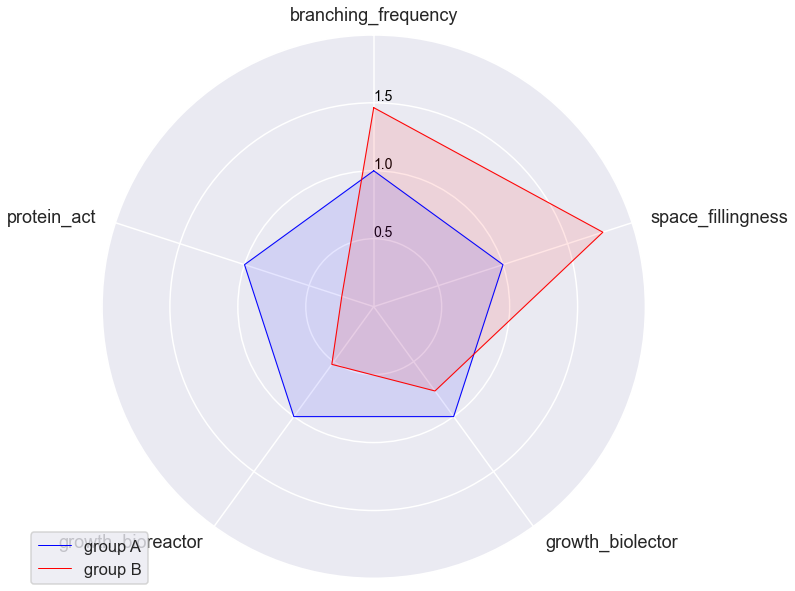

In [278]:
# Libraries

plt.rcParams["axes.axisbelow"] = True
    
    
# Set data
ms_df_fin = ms_df[["gene", "branching_frequency", "space_fillingness", 
                   "growth_biolector", "growth_bioreactor", "protein_act"]]
 
df = ms_df_fin
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
f = plt.figure(figsize=[10,10])
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, size=18)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.5,1,1.5], ["0.5","1.0","1.5"], color="k", size=14)
plt.ylim(0,2)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=[1,1,1,1,1]
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A", color="b")
ax.fill(angles, values, color='b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('gene').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B", color="r")
ax.fill(angles, values, color='r', alpha=0.1)
 
alignments = ["center", "left", "left", "right", "right"]
for i,label in enumerate(ax.get_xticklabels()):
    label.set_ha(alignments[i])
    
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))